Importing Important Libraries

In [1]:
import warnings

# import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

# Plots and stats
import matplotlib.pyplot as plt
import seaborn as sns

# Label Encoding & Scaling
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# Model Building
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Resampling and parameters
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import GridSearchCV

Importing Dataset

In [2]:
df = pd.read_csv("credit_risk_dataset.csv")
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


Data Cleaning

In [3]:
df_encoded = df.copy()
label_encoders = {}
columns_to_encode = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# Encoding categorical columns and replacing them with encoded versions
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    df_encoded[column] = label_encoders[column].fit_transform(df_encoded[column])

df_encoded.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,3,123.0,4,3,35000,16.02,1,0.59,1,3
1,21,9600,2,5.0,1,1,1000,11.14,0,0.10,0,2
2,25,9600,0,1.0,3,2,5500,12.87,1,0.57,0,3
3,23,65500,3,4.0,3,2,35000,15.23,1,0.53,0,2
4,24,54400,3,8.0,3,2,35000,14.27,1,0.55,1,4


In [4]:
# Loop through each column to check encoding
for column in columns_to_encode:
    original_values = df[column].unique()
    encoded_column = column
    encoded_values = df_encoded[encoded_column].unique()

    print(f"{column}:")
    for orig, enc in zip(original_values, encoded_values):
        print(f"'{orig}' in df --> '{enc}'")

person_home_ownership:
'RENT' in df --> '3'
'OWN' in df --> '2'
'MORTGAGE' in df --> '0'
'OTHER' in df --> '1'
loan_intent:
'PERSONAL' in df --> '4'
'EDUCATION' in df --> '1'
'MEDICAL' in df --> '3'
'VENTURE' in df --> '5'
'HOMEIMPROVEMENT' in df --> '2'
'DEBTCONSOLIDATION' in df --> '0'
loan_grade:
'D' in df --> '3'
'B' in df --> '1'
'C' in df --> '2'
'A' in df --> '0'
'E' in df --> '4'
'F' in df --> '5'
'G' in df --> '6'
cb_person_default_on_file:
'Y' in df --> '1'
'N' in df --> '0'


In [5]:
df_encoded['loan_status'].value_counts()

loan_status
0    25473
1     7108
Name: count, dtype: int64

In [6]:
df_encoded.nunique()

person_age                      58
person_income                 4295
person_home_ownership            4
person_emp_length               36
loan_intent                      6
loan_grade                       7
loan_amnt                      753
loan_int_rate                  348
loan_status                      2
loan_percent_income             77
cb_person_default_on_file        2
cb_person_cred_hist_length      29
dtype: int64

In [7]:
df_encoded.describe()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,32581.000000,31686.000000,32581.000000,32581.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,1.676222,4.789686,2.533839,1.218195,9589.371106,11.011695,0.218164,0.170203,0.176330,5.804211
std,6.348078,6.198312e+04,1.433116,4.142630,1.731182,1.166336,6322.086646,3.240459,0.413006,0.106782,0.381106,4.055001
min,20.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,500.000000,5.420000,0.000000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,0.000000,2.000000,1.000000,0.000000,5000.000000,7.900000,0.000000,0.090000,0.000000,3.000000
50%,26.000000,5.500000e+04,3.000000,4.000000,3.000000,1.000000,8000.000000,10.990000,0.000000,0.150000,0.000000,4.000000
75%,30.000000,7.920000e+04,3.000000,7.000000,4.000000,2.000000,12200.000000,13.470000,0.000000,0.230000,0.000000,8.000000
max,144.000000,6.000000e+06,3.000000,123.000000,5.000000,6.000000,35000.000000,23.220000,1.000000,0.830000,1.000000,30.000000


In [8]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  int64  
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  int64  
 5   loan_grade                  32581 non-null  int64  
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  int64  
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 3.0 MB


In [9]:
df_encoded.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [10]:
#Filling NA/missing values
df_encoded.fillna(df_encoded["loan_int_rate"].mean(),inplace=True)
df_encoded.fillna(df_encoded["person_emp_length"].mean(),inplace=True)

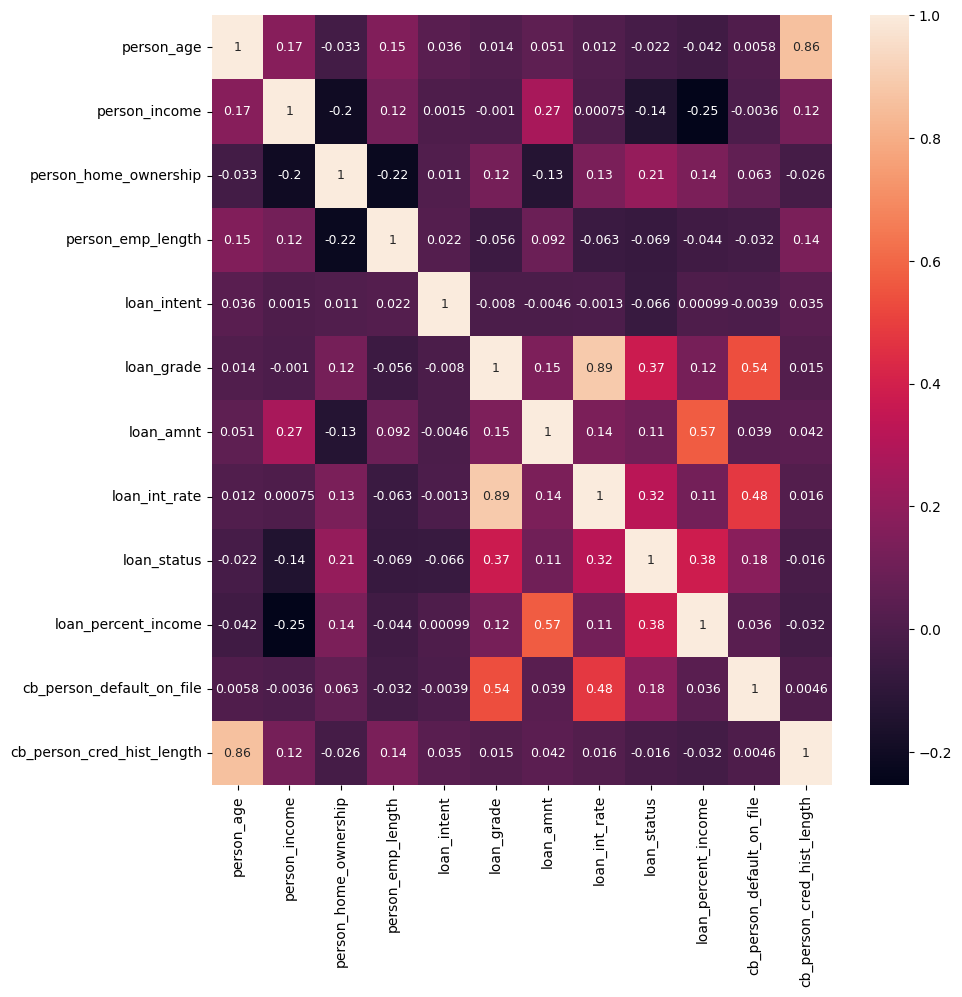

In [11]:
correlations = df_encoded.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(correlations, annot=True, annot_kws={"size": 9})  # Adjust the font size as per your preference
correlations.round(1)
plt.show()
# By this we can examine our informed decisions about which variables to include in predictive models, identify redundant variables, and gain insights into the underlying structure of the dataset. Identifying correlations between certain borrower attributes and default rates can help in building more accurate predictive models.

<Axes: xlabel='person_age', ylabel='count'>

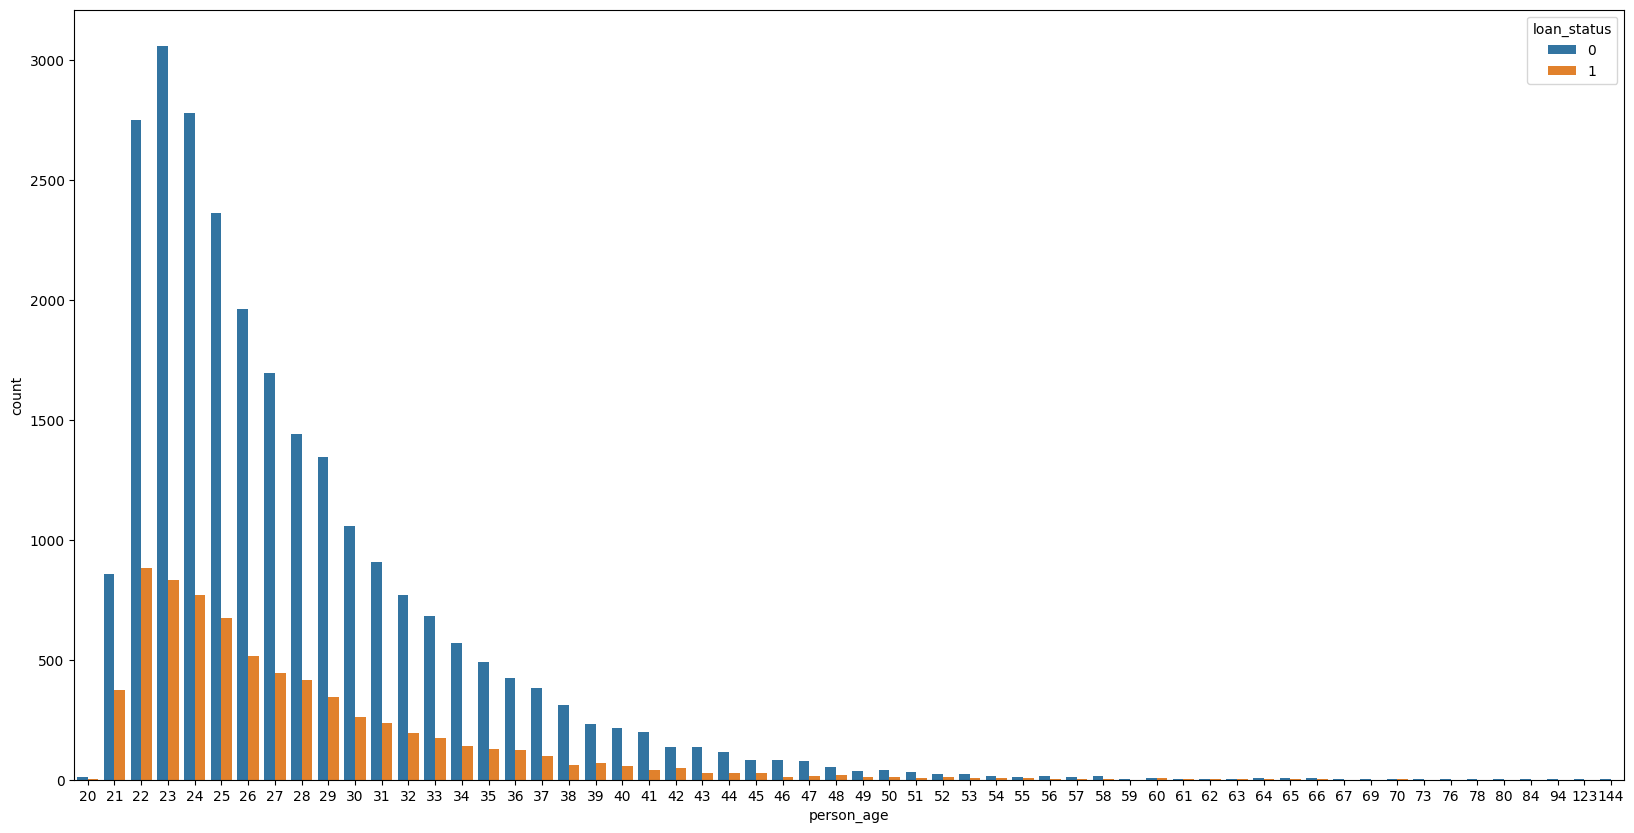

In [12]:
plt.figure(figsize=[20,10])
sns.countplot(x = 'person_age', hue= 'loan_status', data=df_encoded)

# We notice a trend where younger individuals tend to default on their loans more frequently, with a higher proportion of defaults among this demographic.

In [13]:
from IPython.core.display import HTML

# Accepts a list of IpyTable objects and returns a table which contains each IpyTable in a cell
def multi_table(table_list):
    # Create HTML code for each table
    table_html_list = []
    for table in table_list:
        table_html_list.append('<td style="background-color: #FFFFFF; border: 1px solid #000000; color: #000000;">' + table._repr_html_() + '</td>')
    # Concatenate the HTML code for all tables
    html_content = ''.join(table_html_list)
    html_row = '<tr>' + html_content + '</tr>'
    html_table = '<table>' + html_row + '</table>'

    
    return HTML(html_table)

nunique_df = {
    var: pd.DataFrame(df_encoded[var].value_counts())
    for var in {
        'person_age', 'person_income', 'person_home_ownership',
        'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
        'loan_int_rate', 'loan_status', 'loan_percent_income',
        'cb_person_default_on_file', 'cb_person_cred_hist_length'
    }
}
multi_table([
    nunique_df['person_age'], nunique_df['person_income'], 
    nunique_df['person_home_ownership'], nunique_df['person_emp_length'], 
    nunique_df['loan_intent'], nunique_df['loan_grade'], 
    nunique_df['loan_amnt'], nunique_df['loan_int_rate'], 
    nunique_df['loan_status'], nunique_df['loan_percent_income'], 
    nunique_df['cb_person_default_on_file'], nunique_df['cb_person_cred_hist_length']
])

# This helps us to analyze the distribution and diversity of values within each feature of the dataset, which is useful for understanding the characteristics of the data before applying unsupervised learning algorithms for credit default prediction. For example, you can assess the range of ages, income levels, loan amounts, interest rates, etc., which can provide insights into the demographics and financial attributes of borrowers.

,count
person_age,
23,3889
22,3633
24,3549
25,3037
26,2477
27,2138
28,1854
29,1687
30,1316


In [14]:
import plotly.express as px
debtor = df[df['loan_status'] == 1]
fig1 = px.histogram(debtor, x='loan_intent', color='loan_intent', template='plotly_dark')
fig1.update_layout(width=800)
fig1.show()
# People most likely to default on the loan are the youngest, and the biggest expense on loans is for medical expenses. One of the reasons may be that many do not have health insurance and, in an emergency, end up borrowing money.

/home/kanishk/.local/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [15]:
import plotly.express as px
no_debtor = df[df['loan_status'] == 0]
fig1 = px.histogram(no_debtor, x='loan_intent', color='loan_intent', template='plotly_dark')
fig1.update_layout(width=800)
fig1.show()
# In this graph we can see that those who pay the loan used the amount to pay the student loan, hence the education factor ends up being an interesting one for the repayment.

/home/kanishk/.local/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



/home/kanishk/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning:

The markers list has more values (32581) than needed (2), which may not be intended.

/home/kanishk/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning:

The markers list has more values (32581) than needed (2), which may not be intended.

/home/kanishk/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning:

The markers list has more values (32581) than needed (2), which may not be intended.

/home/kanishk/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning:

The markers list has more values (32581) than needed (2), which may not be intended.

/home/kanishk/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning:

The markers list has more values (32581) than needed (2), which may not be intended.

/home/kanishk/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning:

The markers list has more valu

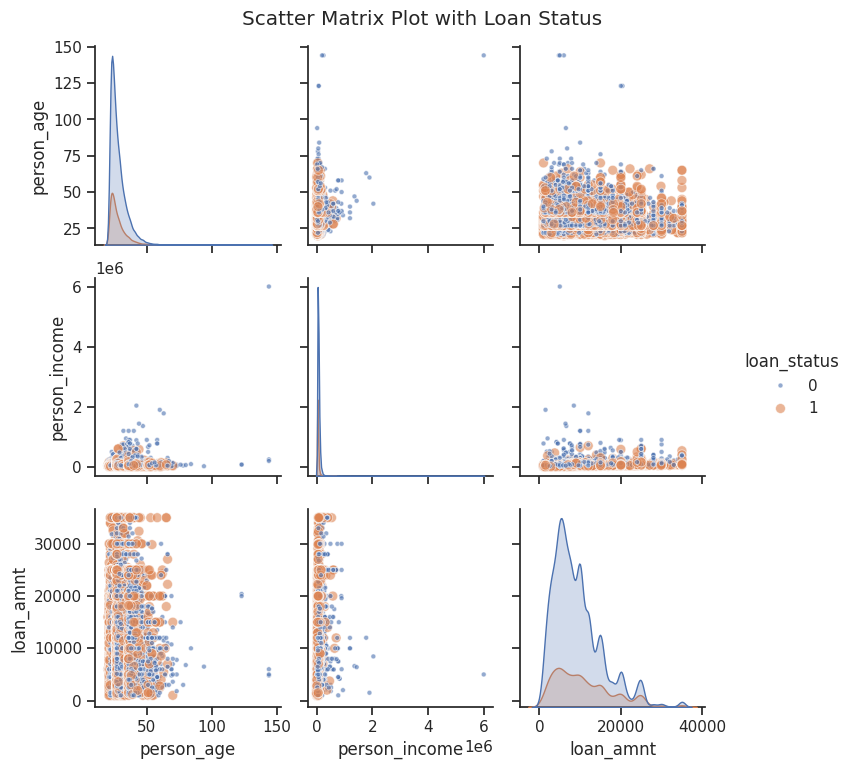

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Each category of 'loan_status'
marker_styles = ['o', '.']

# Map loan_status values to markers
marker_dict = {0: marker_styles[0], 1: marker_styles[1]}

# scatter matrix plot with customizations
sns.set(style='ticks')
sns.pairplot(
    df_encoded,
    hue='loan_status',
    vars=['person_age', 'person_income', 'loan_amnt'],
    markers=[marker_dict[val] for val in df_encoded['loan_status']],
    plot_kws={'alpha': 0.6, 's': 50},  # Adjust marker transparency and size
)
plt.suptitle('Scatter Matrix Plot with Loan Status', y=1.02)
plt.show()

# Person age to person income shows, adults as in 40s, always have more income then any age group around.Loan amt to Person age shows, the growing, teens and adults are the only 2 in need for the loans, as for the upcoming future.

Splitting Sets

In [17]:
X = df_encoded.drop(columns=['loan_status'])
Y = df_encoded['loan_status']

In [18]:
# Split the dataset into training and temporary set (80% training, 20% temp set)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

print("Training set shapes:")
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("\nTest set shapes:")
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)

Training set shapes:
X_train: (26064, 11)
Y_train: (26064,)

Test set shapes:
X_test: (6517, 11)
Y_test: (6517,)


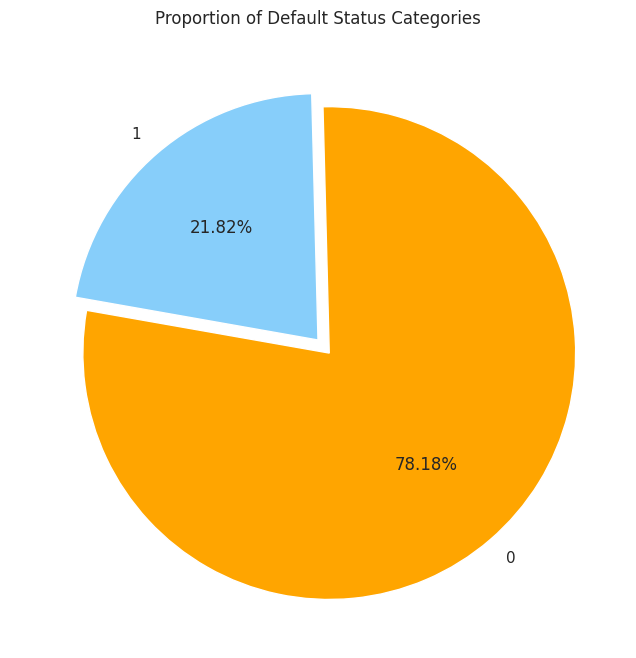

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
counts = df['loan_status'].value_counts()
labels = counts.index
sizes = counts.values
# Explode the first slice
explode = (0.07, 0)
fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%.2f%%', startangle=170, colors=["orange", "lightskyblue"])
ax1.set_title("Proportion of Default Status Categories")
plt.show()

Correcting the Imbalance

In [20]:
# Fit predictor and target variable
rus = RandomUnderSampler(random_state=42, replacement=True)
x_rus, y_rus = rus.fit_resample(X_train, Y_train)

print('Original dataset shape:', Counter(Y_train)) 
print('Undersampled dataset shape', Counter(y_rus))

Original dataset shape: Counter({0: 20401, 1: 5663})
Undersampled dataset shape Counter({0: 5663, 1: 5663})


In [21]:
ros = RandomOverSampler(random_state=42) 
# Fit predictor and target variables
x_ros, y_ros = ros.fit_resample(X_train, Y_train) 

print('Original dataset shape:', Counter(Y_train))
print('Oversampled dataset shape:', Counter(y_ros))

Original dataset shape: Counter({0: 20401, 1: 5663})
Oversampled dataset shape: Counter({0: 20401, 1: 20401})


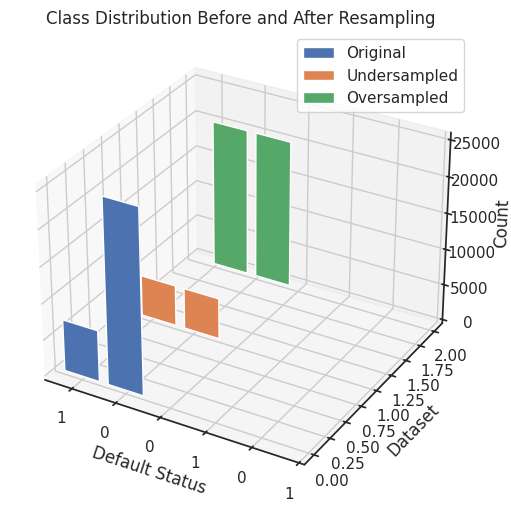

In [22]:
original_counter = Counter(Y)
undersampled_counter = Counter(y_rus)
oversampled_counter = Counter(y_ros)

# Combine the data into a single DataFrame
data = pd.DataFrame({
    'Class': list(original_counter.keys()) + list(undersampled_counter.keys()) + list(oversampled_counter.keys()),
    'Count': list(original_counter.values()) + list(undersampled_counter.values()) + list(oversampled_counter.values()),
    'Dataset': ['Original'] * len(original_counter) + ['Undersampled'] * len(undersampled_counter) + ['Oversampled'] * len(oversampled_counter)
})

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
# Iterate through the data and plot bars
for i, dataset in enumerate(data['Dataset'].unique()):
    dataset_data = data[data['Dataset'] == dataset]
    x_pos = np.arange(len(dataset_data['Class']))
    heights = dataset_data['Count']
    ax.bar(x_pos + i*0.2, heights, zs=i, zdir='y', label=dataset)

ax.set_xlabel('Default Status')
ax.set_ylabel('Dataset')
ax.set_zlabel('Count')
ax.set_xticks(np.arange(len(data['Class'])))
ax.set_xticklabels(data['Class'])
ax.legend()
plt.title('Class Distribution Before and After Resampling')
plt.show()

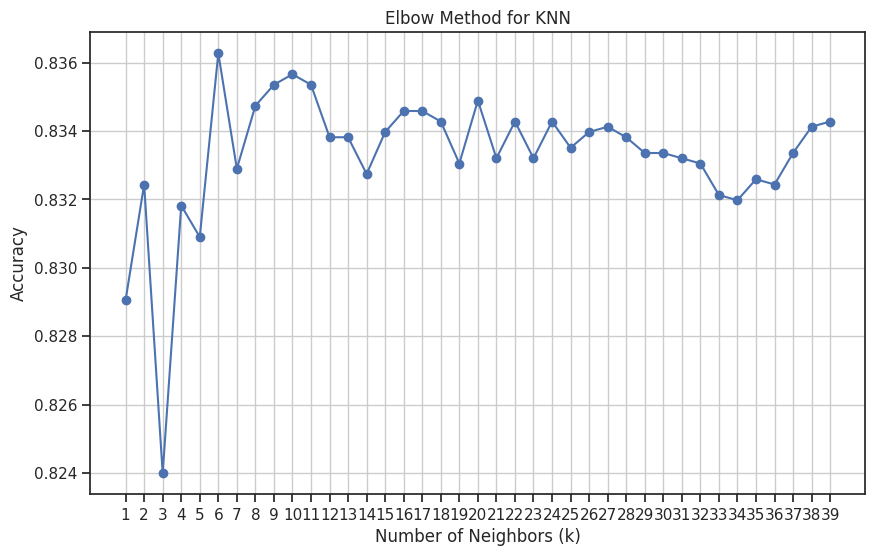

In [23]:
k_values = range(1, 40)
accuracy_scores = []
# Iterate over each value of k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    # Calculate accuracy scores on test set
    accuracy = knn.score(X_test, Y_test)
    accuracy_scores.append(accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-')
plt.title('Elbow Method for KNN')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# More the accuracy, more suitable that k-value is, but elbow method prescribes the k-value to be, after which graph tends to gets stable.

K-Nearest Neighbors (KNN) classification using standardized data and dimensionality reduction (PCA).

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_rus)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

precision_scores = []
recall_scores = []
f1_scores = []
# Evaluation metrics for different values of k
scores = {}
# Define the parameter grid
param_grid = {'n_neighbors': range(1, 27)}
KNN = KNeighborsClassifier()
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=KNN, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_rus)
# Get the best parameters
best_params = grid_search.best_params_
best_k = best_params['n_neighbors']
# Best estimator
best_estimator = grid_search.best_estimator_

for k in range(1, 27):
    # Classifying the query point using KNN by choosing appropriate number of k
    KNN = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    KNN.fit(X_train_pca, y_rus)
    y_pred = KNN.predict(X_test_pca)
    # Getting table of evaluation metrics
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    scores[k] = {'Precision': precision, 'Recall': recall, 'F1-Score': f1}

# Best estimator to predict
y_pred_best = best_estimator.predict(X_test_pca)
accuracy = accuracy_score(Y_test, y_pred_best)
print("Best k:", best_k)
print("Accuracy:", accuracy)

Best k: 9
Accuracy: 0.8032837195028387


K-Nearest Neighbors (KNN) classification without using standardized data and dimensionality reduction (PCA).

In [25]:
precision_scores = []
recall_scores = []
f1_scores = []
# Evaluation metrics for different values of k
scores = {}
# Define the parameter grid
param_grid = {'n_neighbors': range(1, 27)}
KNN = KNeighborsClassifier()
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=KNN, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
# Get the best parameters
best_params = grid_search.best_params_
best_k = best_params['n_neighbors']
# Best estimator
best_estimator = grid_search.best_estimator_

for k in range(1, 27):
    # Classifying the query point using KNN by choosing appropriate number of k
    KNN = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    KNN.fit(X_train, Y_train)
    y_pred = KNN.predict(X_test)
    # Getting table of evaluation metrics
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    scores[k] = {'Precision': precision, 'Recall': recall, 'F1-Score': f1}

# Best estimator to predict
y_pred_best = best_estimator.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred_best)
print("Best k:", best_k)
print("Accuracy:", accuracy)

Best k: 26
Accuracy: 0.8339726868190885


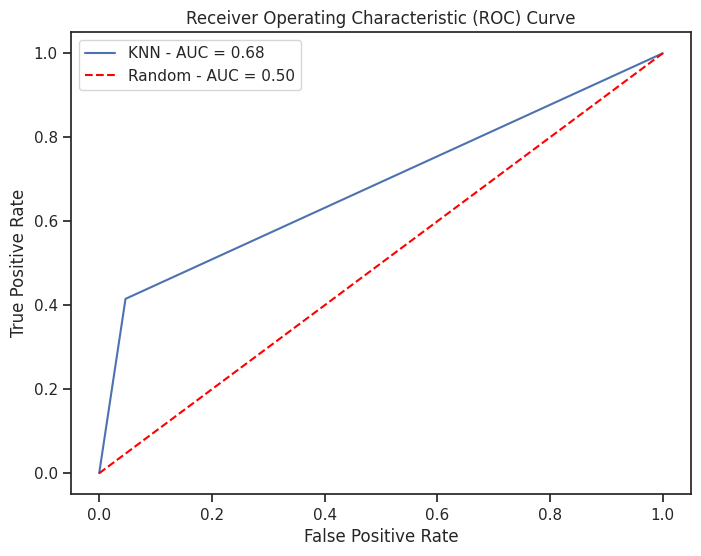

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 10, metric = 'minkowski', p = 2)
classifier.fit(X_train, Y_train)
y_predKNN = classifier.predict(X_test)

from sklearn.metrics import roc_curve, auc

# Assuming you have calculated the ROC curve for KNN model as shown in your code

# Plotting ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
plt.plot(fpr, tpr, label=f'KNN - AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random - AUC = 0.50')  
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# ROC Curve (Orange Line): It plots the trade-off between true positive rate and false positive rate as the classification threshold varies.
# Area Under the Curve (AUC): A higher AUC value (closer to 1) indicates better discrimination ability of the model. In this case, an AUC of 0.68 suggests that the model performs better than random guessing but still need improvement. Since the ROC curve is above the diagonal, it indicates that the model performs better.

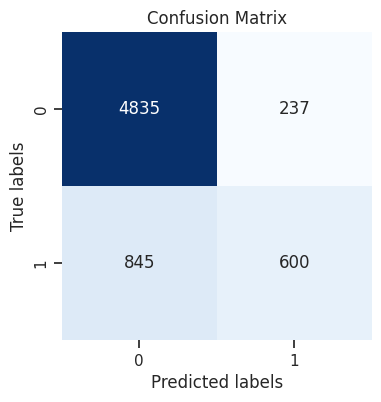

In [27]:
# Calculate confusion matrix for the best estimator
conf_matrix = confusion_matrix(Y_test, y_pred_best)

# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

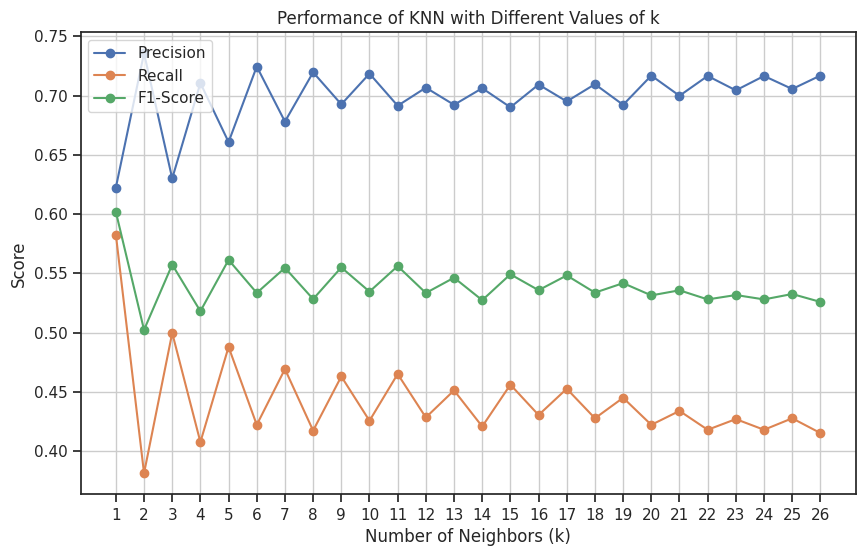

In [28]:
# Extract k values and evaluation metrics from the 'scores' dictionary
k_values = list(scores.keys())
precision_values = [scores[k]['Precision'] for k in k_values]
recall_values = [scores[k]['Recall'] for k in k_values]
f1_values = [scores[k]['F1-Score'] for k in k_values]

plt.figure(figsize=(10, 6))
plt.plot(k_values, precision_values, marker='o', label='Precision')
plt.plot(k_values, recall_values, marker='o', label='Recall')
plt.plot(k_values, f1_values, marker='o', label='F1-Score')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Score')
plt.title('Performance of KNN with Different Values of k')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()
# Precision keeps increasing with k values further and further, whereas both recall and f1-score are decreasing, moreover all of them are varying less with increasing time.

In [29]:
level_counts=df.person_home_ownership.value_counts()
fig=px.pie(values=level_counts.values,
          names=level_counts.index,
          color_discrete_sequence=px.colors.sequential.Mint,
          )
fig.update_traces(textinfo='label+percent+value', textfont_size=13,
                  marker=dict(line=dict(color='#102000', width=0.2)))

fig.data[0].marker.line.width = 2
fig.data[0].marker.line.color='gray'
fig.show()
# Observations: Most of the People taking a loan doesnt have their own house

Decision trees using standardized data and dimensionality reduction(PCA).

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_rus)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define the hyperparameters grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train_pca, y_rus)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='f1')
# Fit GridSearchCV to the resampled training data
grid_search.fit(X_train_pca, y_rus)
# Get the best parameters and best F1 score
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best F1 Score:", best_f1_score)

# Predict on the test set
y_pred_test = grid_search.predict(X_test_pca)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(Y_test, y_pred_test)
print("Test Set Accuracy:", test_accuracy)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best F1 Score: 0.7728927896426293
Test Set Accuracy: 0.7326990946754641


Decision trees without using standardized data and dimensionality reduction(PCA).

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best F1 Score: 0.8011858986215593
Test Set Accuracy: 0.9255792542580942


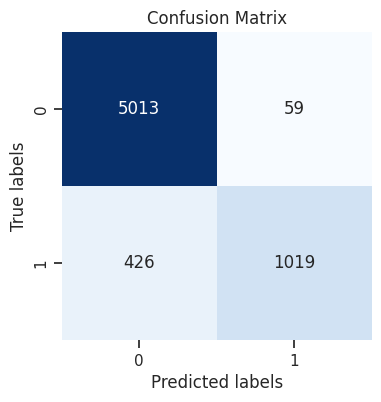

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
# Define the hyperparameters grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Initialize the Decision Tree classifier
clf = DecisionTreeClassifier(criterion='entropy')
# Train the classifier on the resampled training data
clf.fit(X_train, Y_train)
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='f1')

# Fit GridSearchCV to the resampled training data
grid_search.fit(X_train, Y_train)

# Get the best parameters and best F1 score
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best F1 Score:", best_f1_score)

# Predict on the test set
y_pred_test = grid_search.predict(X_test)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(Y_test, y_pred_test)
print("Test Set Accuracy:", test_accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(Y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

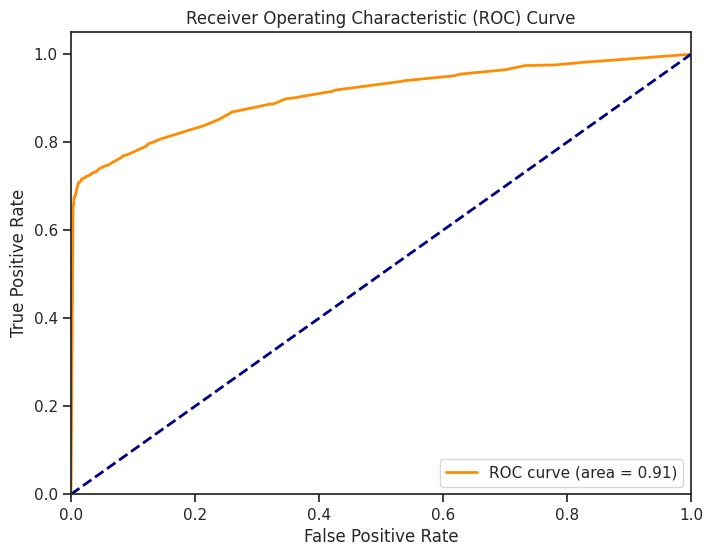

In [32]:
# Plot ROC curve
y_pred_prob = grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = roc_auc_score(Y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [33]:
# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}

svm = SVC(kernel="rbf", gamma=0.5, C=1.0)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train_scaled, y_rus)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy Score: {:.2f}%".format(grid_search.best_score_ * 100))

best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_scaled, y_rus)

# Predict the labels of the test set
Y_test_pred = best_svm_model.predict(X_test_scaled)

test_accuracy = accuracy_score(Y_test, Y_test_pred)
print("Test Accuracy:", test_accuracy)

Best Hyperparameters:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best Accuracy Score: 81.90%
Test Accuracy: 0.8476292772748197


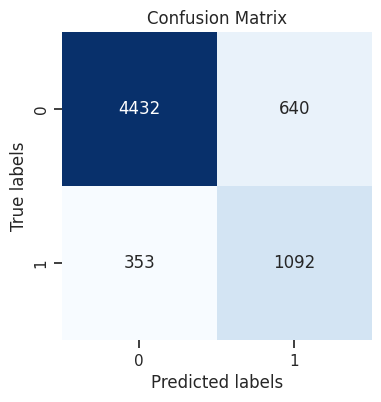

In [34]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

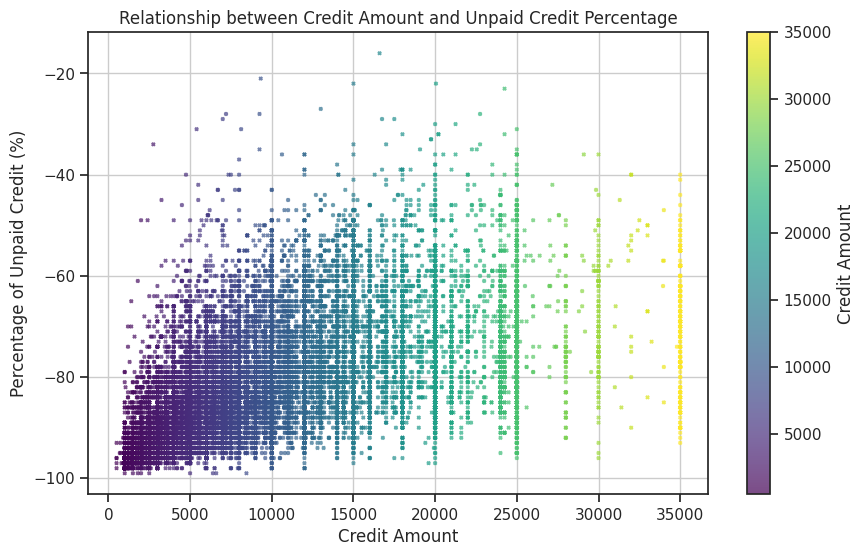

In [35]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Calculate the total amount of existing credits paid
df['total_existing_credits_paid'] = df['loan_amnt'] * (1 - df['loan_percent_income'])

df['payment_capacity_ratio'] = df['total_existing_credits_paid'] / df['loan_amnt']

# Plot the total existing credits paid as a percentage of the loan amount against the credit amount
plt.figure(figsize=(10, 6))
plt.scatter(df['loan_amnt'], (1 - df['payment_capacity_ratio'] * 100), c=df['loan_amnt'], cmap='viridis', s=5, alpha=0.7, marker="x")

# Customize the plot
plt.xlabel('Credit Amount')
plt.ylabel('Percentage of Unpaid Credit (%)')
plt.title('Relationship between Credit Amount and Unpaid Credit Percentage')
plt.colorbar(label='Credit Amount')
plt.grid(True)

# Show the plot
plt.show()

# Positive Trend: The linear regression line indicates a positive trend, suggesting that as the credit amount increases, the percentage of unpaid credit also tends to increase. This implies that borrowers with higher loan amounts may have a higher percentage of unpaid credit, indicating potential financial strain or difficulty in managing existing debts relative to their income.

/tmp/ipykernel_3969/147489942.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




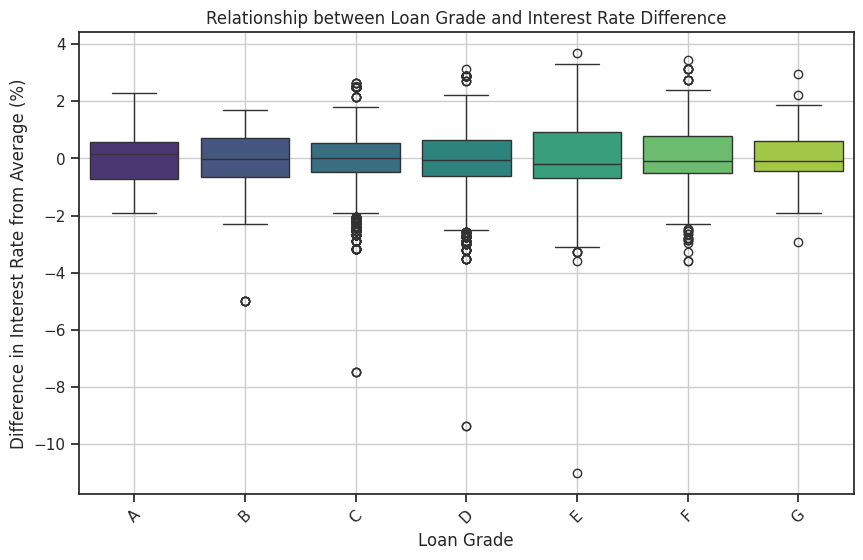

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

avg_int_rate = df.groupby('loan_grade')['loan_int_rate'].mean()

# Difference between the interest rate and the average interest rate for each grade
df['int_rate_difference'] = df.apply(lambda row: row['loan_int_rate'] - avg_int_rate[row['loan_grade']], axis=1)

# Between loan grade and the difference in interest rates
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_grade', y='int_rate_difference', data=df, order=sorted(df['loan_grade'].unique()), palette='viridis')
plt.xlabel('Loan Grade')
plt.ylabel('Difference in Interest Rate from Average (%)')
plt.title('Relationship between Loan Grade and Interest Rate Difference')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Grade B,C,D Loans: Tend to have interest rates closer to the average rate for these grade loans, with fewer outliers.
# Grade E Loans: Loans with grade E might have a wider spread of interest rates compared to other grades, indicating higher variability, leading to higher risks.

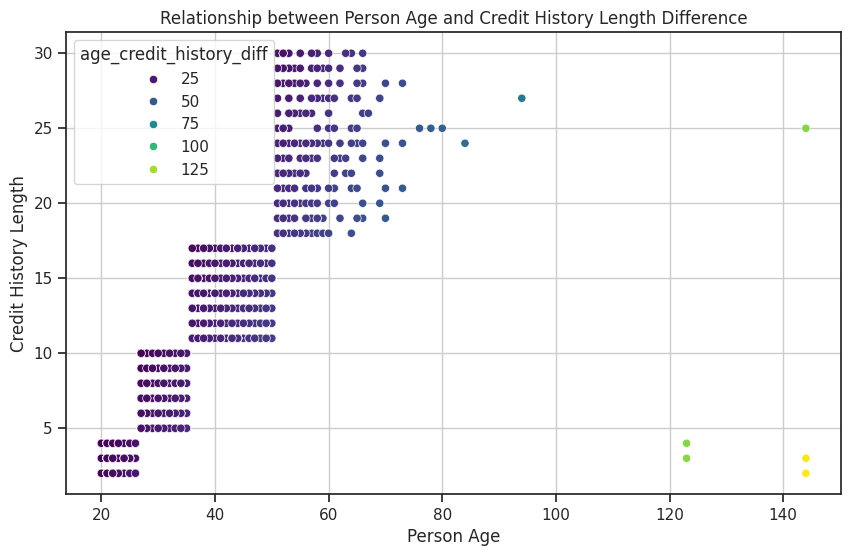

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

df['age_credit_history_diff'] = df['person_age'] - df['cb_person_cred_hist_length']

# Plot the relationship between age and credit history length difference
plt.figure(figsize=(10, 6))
sns.scatterplot(x='person_age', y='cb_person_cred_hist_length', hue='age_credit_history_diff', data=df, palette='viridis')
plt.xlabel('Person Age')
plt.ylabel('Credit History Length')
plt.title('Relationship between Person Age and Credit History Length Difference')
plt.grid(True)
plt.show()

# Positive differences b/w age and credit history indicate individuals who have had credit accounts for a longer time relative to their age, suggesting a history of responsible being. On the other hand, negative differences may indicate individuals who have recently established credit accounts or have shorter credit histories relative to their age. Individuals with unusually long or short credit histories relative to their age group bring further risk to their credit management.